<h1 style='color:Red', align = 'center' >Clothing Images Classification</h1>

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.9.1


### Import the Fashion MNIST dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### Explore the data

In [3]:
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape)

(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

In [4]:
class_names = {0 : 'T-shirt/top', 
               1 : 'Trouser', 
               2 : 'Pullover', 
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 :'Shirt',
               7 :'Sneaker',
               8 :'Bag',
               9 :'Ankle boot'
              }
class_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [5]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Preprocess the data

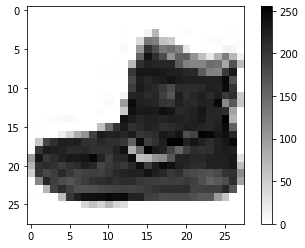

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
class_names[train_labels[0]]

'Ankle boot'

#### Plot the first 50 digit with their actual label

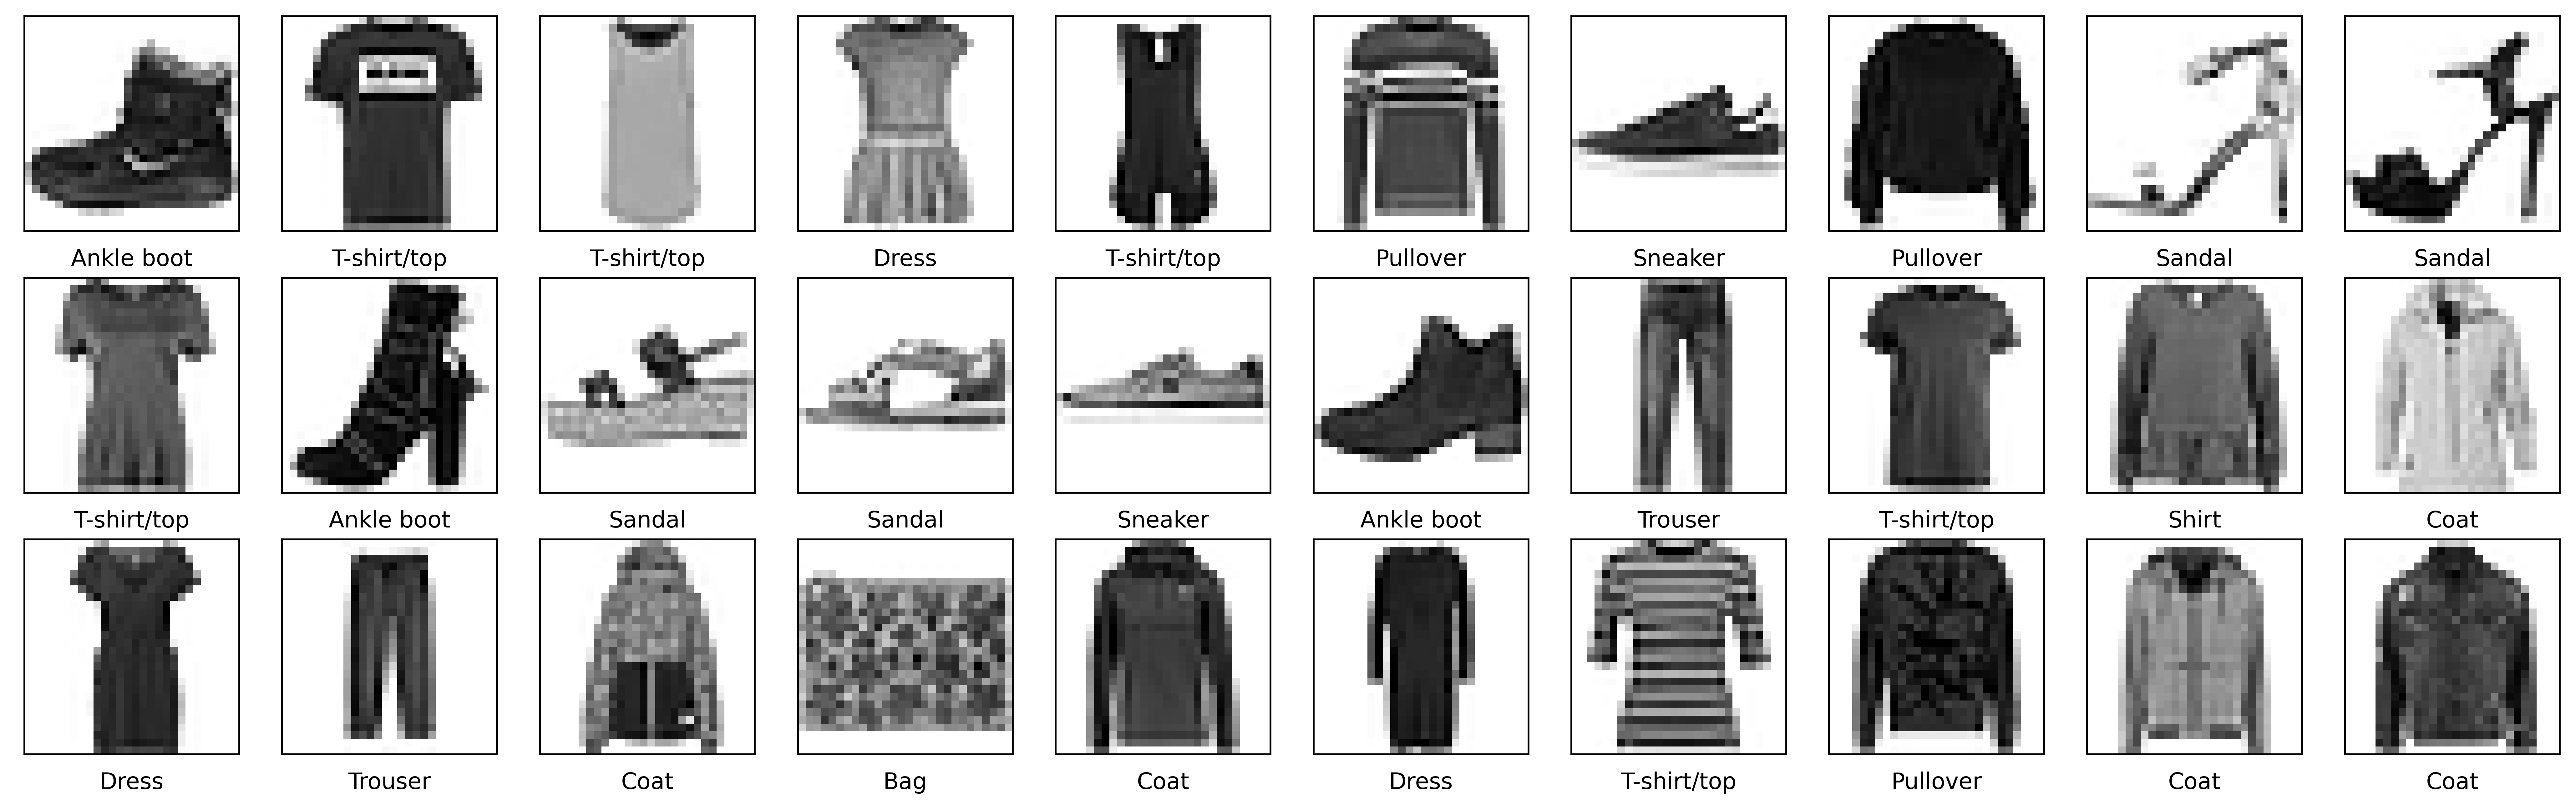

In [8]:
plt.figure(figsize=(20,6), dpi = 523)
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])                   # Adding label as the value of handwritten digit
plt.show()

### Scalling the value for better accuracy

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

### Add a channels dimension

In [10]:
train_images = train_images[..., tf.newaxis].astype("float32")
test_images = test_images[..., tf.newaxis].astype("float32")
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Rotate Shear, Zoom, Shift height of the Image

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range= 15,
                             height_shift_range=0.1,
                             zoom_range=0.11,
                             shear_range=0.11
                            )


datagen.fit(train_images)
datagen.fit(test_images)

### Shuffle the dataset

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

In [32]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

## Build a machine learning model

In [33]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1     = Conv2D(32, 3, activation='relu')
        self.flatten   = Flatten()
        self.d1        = Dense(128, activation='relu')
        self.d2        = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
    
# Create an instance of the model
model = MyModel()

#### Choose an optimizer and loss function for training

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

### Select metrics to measure the loss and the accuracy of the model

In [34]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Use `tf.GradientTape` to train the model:

In [35]:
@tf.function
def train_step(images, labels):
    
    with tf.GradientTape() as tape:
        
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

### Test the model:

In [36]:
@tf.function
def test_step(images, labels):
    
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    
    # Reset the metrics at the start of the next epoch
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 0.35099688172340393, Accuracy: 87.3550033569336, Test Loss: 0.3062640428543091, Test Accuracy: 88.41000366210938
